In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Dataset

In [ ]:
!pip install kmeans logger kmeans-pytorch

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for kmeans: filename=kmeans-1.0.2-cp311-cp311-linux_x86_64.whl size=12527 sha256=8237ec1201856e88ba4bd6eb0f456959012b0f0199ed9477d5d0fe4a5eaccba6
  Stored in directory: /root/.cache/pip/wheels/46/73/c1/99a115afb9caa9d3fa04a35509d96d075f18944cbf2b7bdf9b
  Created wheel for logger: filename=logger-1.4-py3-none-any.whl size=1759 sha256=b4b5d5f9a543c2a1afc22d08c29b5e2777ce95bce150137c88f5d3b12ac57867
  Stored in directory: /root/.cache/pip/wheels/cd/1d/c8/f1361043ff09fd3c9a747b199e8e37bd716bacf0843bbdb68f
Successfully built kmeans logger


In [ ]:
from torch.utils.data import Dataset
from tqdm import tqdm
from pathlib import Path
import numpy as np
import json
import h5py
from PIL import Image
from kmeans_pytorch import kmeans
import torch
import cv2
import random
import gc

# from lib.logger import logger

class ShapenetDataset(Dataset):
    def __init__(self, dataset_path, snapshot_path, transforms=None,
                 only: list = None, mode: str = 'easy', remake: bool = True, shuffle: bool = True, seed: int = None):
        self.dataset_path = dataset_path
        self.snapshot_path = snapshot_path
        self.transforms = transforms
        self.only = only
        self.mode = mode
        self.shuffle = shuffle
        self.seed = seed
        self.remake = remake
        self.length = 0

        print(f"Dataset path: {self.dataset_path}")
        self.data_type = self.dataset_path.stem.split("_files")[0]

        self.h5_files = {}
        self.index_map = []

        for key, value in enumerate(self.only):
            if self.check_final_h5(value) is True and remake is False:
                print(f"Opening HDF5 file for {value}...")
                # source_name, source_file, source_points, \
                #     image_path, gt_points, image = self.read_final_h5(value)
                h5_file = self.read_final_h5(value)
                self.h5_files[value] = h5_file
                num_samples = len(h5_file["image"])
                self.index_map.extend(
                    [(value, i)
                    for i in range(num_samples)
                ])
                self.length = len(self.index_map)

            else:
                source_name, source_file, source_points = self.read_dataset([value])
                image_path, gt_points, length = self.convert2realpath(source_file)

                image = self.open_image(image_path)

                # image = []
                # for batch in self.open_image(image_path):
                #     image.extend(batch)

                source_points = self.points_normalization(source_points)
                # source_points = self.points_classification(source_points)

                self.save_final_h5(value, source_name, source_file, source_points, image_path, gt_points, image)
                del source_name, source_file, source_points, image_path, gt_points, image
                gc.collect()
                h5_file = self.read_final_h5(value)
                self.h5_files[value] = h5_file
                num_samples = len(h5_file["image"])
                self.index_map.extend(
                    [(value, i)
                    for i in range(num_samples)
                ])
                self.length = len(self.index_map)

                # if key == 0:
                #     self.source_name = source_name
                #     self.source_file = source_file
                #     self.source_points = source_points
                #     self.image_path = image_path
                #     self.gt_points = gt_points
                #     self.length = len(image_path)
                #     self.image = image
                # else:
                #     self.source_name = np.concatenate((self.source_name, source_name), 0)
                #     self.source_file = np.concatenate((self.source_file, source_file), 0)
                #     self.source_points = np.concatenate((self.source_points, source_points), 0)
                #     self.image_path = np.concatenate((self.image_path, image_path), 0)
                #     self.gt_points = np.concatenate((self.gt_points, gt_points), 0)
                #     self.length = self.length + len(image_path)
                #     self.image = np.concatenate((self.image, image), 0)

                # if self.length == 0:
                #     raise Exception('no data found')
                # logger.debug(f'Dataset Type: {self.data_type}, Point Model: {len(self.source_points)}, Images: {self.length}')

        # shuffle items because can't use data loader shuffle
        if self.shuffle:
          rng = random.Random(self.seed) if self.seed is not None else random
          rng.shuffle(self.index_map)

    def check_final_h5(self, filename):
        h5_name = f'shapenet_{filename}_{self.data_type}_{self.mode}.h5'
        h5_path = self.snapshot_path.parent.joinpath('h5_v2')
        h5_path.mkdir(parents=True, exist_ok=True)
        return h5_path.joinpath(f'{h5_name}').exists()

    def read_final_h5(self, filename):
        # h5_name = f'shapenet_{filename}_{self.data_type}_{self.mode}.h5'
        # h5_path = self.snapshot_path.parent.joinpath(f'h5/{h5_name}')
        # with h5py.File(h5_path, 'r') as f:
        #     return [
        #         f['source_name'][:], f['source_file'][:], f['source_points'][:],
        #         f['image_path'][:], f['gt_points'][:],
        #         f['image'][:]
        #     ]
        h5_name = f'shapenet_{filename}_{self.data_type}_{self.mode}.h5'
        h5_path = self.snapshot_path.parent.joinpath(f'h5/{h5_name}')
        return h5py.File(h5_path, 'r', swmr=True, libver='latest')

    def save_final_h5(self, filename, source_name, source_file, source_points, image_path, gt_points, image):
        h5_name = f'shapenet_{filename}_{self.data_type}_{self.mode}.h5'
        h5_path = self.snapshot_path.parent.joinpath(f'h5_v2/{h5_name}')
        with h5py.File(h5_path, 'w') as f:
            f.create_dataset('source_name', data=source_name.tolist())
            f.create_dataset('source_file', data=source_file.tolist())
            f.create_dataset('source_points', data=source_points)
            f.create_dataset('image_path', data=image_path.tolist())
            f.create_dataset('gt_points', data=gt_points)
            f.create_dataset('image', data=image)
            # f.create_dataset('image_processed', data=image)

    def read_dataset(self, only):
        all_name, all_file, all_gt_points = np.empty([0]), np.empty([0]), np.empty([0, 2048, 3], dtype=np.float32)
        with open(self.dataset_path, 'r') as f:
            files = f.readlines()
            np_files = np.char.split(files, sep='\n')
        read_bar = tqdm(np_files, unit='file', leave=True, colour='#DA7E7E')
        for key, value in enumerate(read_bar):
            index = value[0].split('.')[0]
            prefix_path = Path(self.dataset_path).parent.parent.joinpath(f"{Path(index).parent.name}")
            name_json = prefix_path.joinpath(f"{Path(index).name}_id2name.json")
            file_json = prefix_path.joinpath(f"{Path(index).name}_id2file.json")
            h5 = prefix_path.joinpath(f"{Path(index).name}.h5")

            with open(name_json) as f:
                name = np.array(json.load(f))

            if only is not None:
                target_cls = np.isin(name, only)
            else:
                target_cls = tuple()

            name = name[target_cls]

            with open(file_json) as f:
                file = np.array(json.load(f))[target_cls]

            with h5py.File(h5, 'r') as f:
                h5_data = f['data'][:][target_cls]

            read_bar.set_description(f'Read Dataset (File) ({only}) [{key + 1}/{len(np_files)}]')
            read_bar.set_postfix_str(f'Count: {len(name)}')

            all_name = np.concatenate((all_name, name), 0)
            all_file = np.concatenate((all_file, file), 0)
            all_gt_points = np.concatenate((all_gt_points, h5_data), 0)
        return all_name, all_file, all_gt_points

    def points_normalization(self, source_points):
        size = source_points.shape[0]
        n_points = torch.from_numpy(source_points).view(size, -1)
        n_points = n_points - n_points.min(1, keepdim=True)[0]
        n_points = n_points / n_points.max(1, keepdim=True)[0]
        n_points = n_points.view(size, -1, 3)
        return n_points.numpy()

    def points_classification(self, source_points):
        cluster = torch.empty([0, 2048])
        for key, value in enumerate(source_points):
            cluster_ids_x, _ = kmeans(X=torch.from_numpy(value), num_clusters=3, distance='euclidean', tol=1e-4, device='cuda')
            cluster = torch.cat((cluster, cluster_ids_x.view(1, -1)), 0)
        return torch.cat((torch.from_numpy(source_points), cluster.unsqueeze(2)), 2)

    def convert2realpath(self, source_file):
        images, points = np.empty([0]), np.empty([0], dtype=int)
        root_path = Path(self.snapshot_path)
        convert_bar = tqdm(source_file, unit='file', leave=True, colour='#DAB97E')
        for key, value in enumerate(convert_bar):
            dir_path = value.split('.npy')[0]
            current_path = str(root_path.joinpath(f'{dir_path}/{self.mode}'))
            if not Path(current_path).exists():
                continue
            image_count = min(sum(1 for element in Path(current_path).iterdir() if element.suffix == '.png'), 24)
            # only read 24 images
            scope = np.array(list(map('{:02d}.png'.format, np.arange(image_count))))
            png_files = np.char.add(f'{str(current_path)}/', scope)

            images = np.concatenate((images, png_files), 0)
            points = np.concatenate((points, np.full(png_files.shape, key, dtype=int)), 0)

            convert_bar.set_description(f'Convert Dataset (Point Model) [{key + 1}/{len(source_file)}]')
            convert_bar.set_postfix_str(f'Image Count: {image_count}')
        return images, points, len(images)

    # def open_image(self, image_path, batch_size=100):
    #     open_bar = tqdm(range(0, len(image_path), batch_size), unit='batch', leave=True, colour='#DADA7E')
    #     for i in open_bar:
    #         batch_paths = image_path[i:i+batch_size]
    #         images = []

    #         for value in batch_paths:
    #             img = cv2.imread(value, cv2.IMREAD_COLOR)
    #             if img is None:
    #                 continue

    #             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #             if self.transforms is not None:
    #                 img = self.transforms(img)

    #             images.append(img)

    #         open_bar.set_description(f'Open Image (Batch) [{i+1}/{len(image_path)}]')

    #         yield images


    # def open_image(self, image_path):
    #     images = []
    #     open_bar = tqdm(image_path, unit='file', leave=True, colour='#DADA7E')

    #     for key, value in enumerate(open_bar):
    #         img = cv2.imread(value, cv2.IMREAD_COLOR)
    #         if img is None:
    #             continue

    #         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #         if self.transforms is not None:
    #             img = self.transforms(img)

    #         images.append(img)

    #         open_bar.set_description(f'Open Image (File) [{key + 1}/{len(image_path)}]')

    #     return images

    def open_image(self, image_path):
        image = []
        open_bar = tqdm(image_path, unit='file', leave=True, colour='#DADA7E')
        for key, value in enumerate(open_bar):
            image += [Image.open(value).copy()]
            image[-1] = image[-1].convert("RGB")
            if self.transforms is not None:
                image[-1] = self.transforms(image[-1]).numpy()
                # transformed_image = self.transforms(image[-1])
                # transformed_image_np = transformed_image.numpy()
                # transformed_image = transformed_image.unsqueeze(0).to(device)
                # with torch.no_grad():
                #     depth_prediction = midas(transformed_image)
                # depth_prediction = depth_prediction.squeeze().cpu().numpy()
                # depth_prediction = (depth_prediction - depth_prediction.min()) / (depth_prediction.max() - depth_prediction.min())
                # depth_pil = Image.fromarray((depth_prediction * 255).astype(np.uint8))
                # depth_map = self.transforms(depth_pil)
                # depth_map = depth_map.numpy()

                # depth_image_2d = depth_map.squeeze()
                # image[-1] = np.concatenate((transformed_image_np, depth_image_2d[None, :, :]), axis=0)
            if image[-1].dtype == np.float32:
                image[-1] = (image[-1] * 255).astype(np.uint8)

            open_bar.set_description(f'Open Image (File) [{key + 1}/{len(image_path)}]')
        return image

    # def __getitem__(self, index):
    #     return self.image[index], self.source_points[self.gt_points[index]], index

    def __getitem__(self, index):
        file_key, item_idx = self.index_map[index]
        h5_file = self.h5_files[file_key]
        gt_points = h5_file['gt_points'][item_idx]
        image = h5_file['image_processed'][item_idx].astype(np.float32)
        source_points = h5_file['source_points']

        if image.shape[0] != 4:
            raise ValueError(f"Expected image to have 4 channels, but got {image.shape}")
        return image, source_points[gt_points], index


    def __len__(self):
        if self.remake is False :
          return len(self.index_map)
        else :
          return self.length

In [ ]:
from torchvision import transforms
def transform_config(preprocess_list, resize):
        preprocess = []
        if 'grayscale' in preprocess_list:
            preprocess += [transforms.Grayscale(1)]
        if 'resize' in preprocess_list:
            preprocess += [transforms.Resize(resize)]
        if 'totensor' in preprocess_list:
            preprocess += [transforms.ToTensor()]
        return transforms.Compose(preprocess)

In [ ]:
# test if the function data loader works properly
from torch.utils.data import DataLoader
from pathlib import Path
import os

image_path = Path("/content/drive/MyDrive/data/Capstone/image")
# shapenet_path = "/content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048"

train_dataset_path = Path('/content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048_downsampled_v3/train_files.txt')
val_dataset_path = Path('/content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048_downsampled_v3/val_files.txt')
test_dataset_path = Path('/content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048_downsampled_v3/test_files.txt')

# preprocess = ['grayscale', 'resize', 'totensor']
preprocess = ['resize', 'totensor']

# create train Dataset
train_dataset = ShapenetDataset(
    dataset_path=train_dataset_path,
    snapshot_path=image_path,
    only=["bench", "lamp", "cabinet", "sofa", "table", "chair"],
    only=["chair"],
    mode="easy",
    transforms=transform_config(preprocess, [128,128]),
    remake=True,
    shuffle=True,
    seed=42
)

val_dataset = ShapenetDataset(
    dataset_path=val_dataset_path,
    snapshot_path=image_path,
    only=["bench", "lamp", "cabinet", "sofa", "table", "chair"],
    mode="easy",
    transforms=transform_config(preprocess, [128,128]),
    remake=True,
    shuffle=True,
    seed=42
)

test_dataset = ShapenetDataset(
    dataset_path=test_dataset_path,
    snapshot_path=image_path,
    only=["bench", "lamp", "cabinet", "sofa", "table", "chair"],
    mode="easy",
    transforms=transform_config(preprocess, [128,128]),
    remake=False,
    shuffle=True,
    seed=42
)


Dataset path: /content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048_downsampled_v3/train_files.txt


Open Image (File) [46080/46080]: 100%|██████████| 46080/46080 [3:17:52<00:00,  3.88file/s]


Dataset path: /content/drive/MyDrive/data/Capstone/shapenetcorev2_hdf5_2048_downsampled_v3/val_files.txt


Open Image (File) [3754/5568]:  67%|██████▋   | 3754/5568 [16:22<06:30,  4.65file/s]

## Train model

### Model (Pix2point)

In [ ]:
import torch
from torch import nn


class Pixel2Point(nn.Module):
    def __init__(self, initial_point=0):
        super(Pixel2Point, self).__init__()
        self.layer1 = self.conv_module(1, 32)
        self.layer2 = self.conv_module(32, 64)
        self.layer3 = self.conv_module(64, 128)
        self.layer4 = self.conv_module(128, 256)
        self.layer5 = self.conv_module(256, 256)
        self.layer6 = self.conv_module(256, 256)
        self.layer7 = self.conv_module(256, 256)
        self.fc1 = self.fc_module(256 * (3 + 256), 2048 * 5)
        self.fc2 = self.fc_module(2048 * 5, 2048 * 5)
        self.fc3 = self.fc_module(2048 * 5, 2048 * 4)
        self.fc4 = nn.Linear(2048 * 4, 2048 * 3)
        if initial_point == 2:
            self.initial_point = self.multiple_sphere()
        elif initial_point == 1:
            self.initial_point = self.fibonacci_sphere()
        else:
            self.initial_point = self.fibonacci_sphere()

    def forward(self, x):
        encoder_out = self.layer1(x)
        encoder_out = self.layer2(encoder_out)
        encoder_out = self.layer3(encoder_out)
        encoder_out = self.layer4(encoder_out)
        encoder_out = self.layer5(encoder_out)
        encoder_out = self.layer6(encoder_out)
        fv = self.layer7(encoder_out)
        batch_size = fv.shape[0]

        initial_pc_fv = torch.cat((
            self.initial_point.to(fv.device).view(1, 256, 3).repeat(batch_size, 1, 1),  # torch.Size([batch, 256, 3])
            fv.view(batch_size, 1, 256).repeat(1, 256, 1)  # torch.Size([batch, 256, 256])
        ), dim=2, )  # [batch_size, 256, 259]

        generator_out = self.fc1(initial_pc_fv.view(batch_size, -1))
        generator_out = self.fc2(generator_out)
        generator_out = self.fc3(generator_out)
        generator_out = self.fc4(generator_out)

        return generator_out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def fc_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Linear(in_num, out_num),
            nn.ReLU(),
        )

    def sphere(self, offset=(0, 0, 0)):
        u = torch.linspace(0, 2 * torch.pi, 16)
        v = torch.linspace(0, torch.pi, 16)
        x = torch.flatten(1 * torch.outer(torch.cos(u), torch.sin(v)))
        y = torch.flatten(1 * torch.outer(torch.sin(u), torch.sin(v)))
        z = torch.flatten(1 * torch.outer(torch.ones(torch.Tensor.size(u)), torch.cos(v)))
        return torch.stack((x + offset[0], y + offset[1], z + offset[2]), 1)

    def fibonacci_sphere(self, num_pts=256, offset=(0, 0, 0), radius=1):
        # https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
        indices = torch.arange(0, num_pts, dtype=torch.float32) + 0.5
        phi = torch.arccos(1 - 2*indices/num_pts)
        theta = torch.pi * (1 + 5**0.5) * indices
        x, y, z = torch.cos(theta) * torch.sin(phi), torch.sin(theta) * torch.sin(phi), torch.cos(phi)
        return torch.stack((x * radius + offset[0], y * radius + offset[1], z * radius + offset[2]), 1)

    def multiple_sphere(self):
        sphere_1 = self.fibonacci_sphere(128, (0, -0.8, 0.3), 0.3)
        sphere_2 = self.fibonacci_sphere(128, (0, 0.4, -0.2), 0.3)
        return torch.cat((sphere_1, sphere_2), 0)


### Model (Depth2Point)

In [ ]:
import torch
from torch import nn

class Depth2Point(nn.Module):
    def __init__(self, initial_point=0):
        super(Depth2Point, self).__init__()
        self.layer1 = self.conv_module(4, 32) # input: rgbd image
        self.layer2 = self.conv_module(32, 64)
        self.layer3 = self.conv_module(64, 128)
        self.layer4 = self.conv_module(128, 256)
        self.layer5 = self.conv_module(256, 256)
        self.layer6 = self.conv_module(256, 256)
        self.layer7 = self.conv_module(256, 256)
        self.fc1 = self.fc_module(256 * (3 + 256), 2048 * 5)
        self.fc2 = self.fc_module(2048 * 5, 2048 * 5)
        self.fc3 = self.fc_module(2048 * 5, 2048 * 4)
        self.fc4 = nn.Linear(2048 * 4, 2048 * 3)
        if initial_point == 2:
            self.initial_point = self.multiple_sphere()
        elif initial_point == 1:
            self.initial_point = self.fibonacci_sphere()
        else:
            self.initial_point = self.fibonacci_sphere()
    def forward(self, x):
        encoder_out = self.layer1(x)
        encoder_out = self.layer2(encoder_out)
        encoder_out = self.layer3(encoder_out)
        encoder_out = self.layer4(encoder_out)
        encoder_out = self.layer5(encoder_out)
        encoder_out = self.layer6(encoder_out)
        fv = self.layer7(encoder_out)
        batch_size = fv.shape[0]

        initial_pc_fv = torch.cat((
            self.initial_point.to(fv.device).view(1, 256, 3).repeat(batch_size, 1, 1),  # torch.Size([batch, 256, 3])
            fv.view(batch_size, 1, 256).repeat(1, 256, 1)  # torch.Size([batch, 256, 256])
        ), dim=2, )  # [batch_size, 256, 259]

        generator_out = self.fc1(initial_pc_fv.view(batch_size, -1))
        generator_out = self.fc2(generator_out)
        generator_out = self.fc3(generator_out)
        generator_out = self.fc4(generator_out)

        return generator_out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def fc_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Linear(in_num, out_num),
            nn.ReLU(),
        )

    def sphere(self, offset=(0, 0, 0)):
        u = torch.linspace(0, 2 * torch.pi, 16)
        v = torch.linspace(0, torch.pi, 16)
        x = torch.flatten(1 * torch.outer(torch.cos(u), torch.sin(v)))
        y = torch.flatten(1 * torch.outer(torch.sin(u), torch.sin(v)))
        z = torch.flatten(1 * torch.outer(torch.ones(torch.Tensor.size(u)), torch.cos(v)))
        return torch.stack((x + offset[0], y + offset[1], z + offset[2]), 1)

    def fibonacci_sphere(self, num_pts=256, offset=(0, 0, 0), radius=1):
        # https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
        indices = torch.arange(0, num_pts, dtype=torch.float32) + 0.5
        phi = torch.arccos(1 - 2*indices/num_pts)
        theta = torch.pi * (1 + 5**0.5) * indices
        x, y, z = torch.cos(theta) * torch.sin(phi), torch.sin(theta) * torch.sin(phi), torch.cos(phi)
        return torch.stack((x * radius + offset[0], y * radius + offset[1], z * radius + offset[2]), 1)

    def multiple_sphere(self):
        sphere_1 = self.fibonacci_sphere(128, (0, -0.8, 0.3), 0.3)
        sphere_2 = self.fibonacci_sphere(128, (0, 0.4, -0.2), 0.3)
        return torch.cat((sphere_1, sphere_2), 0)

### Loss function

In [ ]:
!pip install git+https://github.com/facebookresearch/pytorch3d.git

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-r59htgy3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-r59htgy3
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 3987612062f3db5dba609df3552768dcd97b410f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [ ]:
!pip install tensorboardX plotly

In [ ]:
!git clone https://github.com/Colin97/MSN-Point-Cloud-Completion.git
!cd MSN-Point-Cloud-Completion/emd && python3 setup.py build_ext --inplace

Cloning into 'MSN-Point-Cloud-Completion'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 68 (delta 9), reused 8 (delta 8), pack-reused 52 (from 1)
Receiving objects: 100% (68/68), 5.56 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (29/29), done.
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/d

In [ ]:
import sys
sys.path.append("/content/MSN-Point-Cloud-Completion/emd")

In [ ]:
import torch
# from pytorch3d.loss import chamfer_distance as pt3d_cd
from torch import nn
from torch.autograd import Function

###  CD loss
class ChamferDistance():
    def __init__(self) -> None:
        # if not torch.are_deterministic_algorithms_enabled():
        #     self.loss_function = self.non_deterministic
        # else:
        #     self.loss_function = self.deterministic
        self.loss_function = self.deterministic

    def forward(self, p1, p2):
        return self.loss_function(p1, p2)

    def deterministic(self, p1, p2):
        s1 = torch.sum(torch.min(torch.cdist(p1, p2, p=2)**2, 2).values, 1)
        s2 = torch.sum(torch.min(torch.cdist(p2, p1, p=2)**2, 2).values, 1)
        return (torch.sum(s1) + torch.sum(s2)) / (p1.shape[-2] * s1.shape[0]), None

    # def non_deterministic(self, p1, p2):
    #     return pt3d_cd(p1, p2)

    def train_param(self, mode: bool = True):
        pass

In [ ]:
import emd

### Earth mover distance loss
class EmdModule(nn.Module):
    def __init__(self):
        super(EmdModule, self).__init__()
        self.train_param(True)

    def forward(self, input1, input2):
        dist, assignment = EmdFunction.apply(input1, input2, self.eps, self.iters)
        loss = torch.sqrt(dist).mean()
        return loss, None

    def train_param(self, mode: bool = True):
        if mode is True:
            self.eps = 0.002  # 0.05
            self.iters = 500  # 50
        else:
            self.eps = 0.002  # 0.002
            self.iters = 500  # 10000

class EmdFunction(Function):
    @staticmethod
    def forward(ctx, xyz1, xyz2, eps, iters):

        batchsize, n, _ = xyz1.size()
        _, m, _ = xyz2.size()

        assert(n == m)
        assert(xyz1.size()[0] == xyz2.size()[0])
        assert(n % 1024 == 0)
        assert(batchsize <= 512)

        xyz1 = xyz1.contiguous().float().cuda()
        xyz2 = xyz2.contiguous().float().cuda()
        dist = torch.zeros(batchsize, n, device='cuda').contiguous()
        assignment = torch.zeros(batchsize, n, device='cuda', dtype=torch.int32).contiguous() - 1
        assignment_inv = torch.zeros(batchsize, m, device='cuda', dtype=torch.int32).contiguous() - 1
        price = torch.zeros(batchsize, m, device='cuda').contiguous()
        bid = torch.zeros(batchsize, n, device='cuda', dtype=torch.int32).contiguous()
        bid_increments = torch.zeros(batchsize, n, device='cuda').contiguous()
        max_increments = torch.zeros(batchsize, m, device='cuda').contiguous()
        unass_idx = torch.zeros(batchsize * n, device='cuda', dtype=torch.int32).contiguous()
        max_idx = torch.zeros(batchsize * m, device='cuda', dtype=torch.int32).contiguous()
        unass_cnt = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()
        unass_cnt_sum = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()
        cnt_tmp = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()

        emd.forward(xyz1, xyz2, dist, assignment, price, assignment_inv, bid, bid_increments, max_increments, unass_idx, unass_cnt, unass_cnt_sum, cnt_tmp, max_idx, eps, iters)

        ctx.save_for_backward(xyz1, xyz2, assignment)

        return dist, assignment

    @staticmethod
    def backward(ctx, graddist, gradidx):
        xyz1, xyz2, assignment = ctx.saved_tensors
        graddist = graddist.contiguous()

        gradxyz1 = torch.zeros(xyz1.size(), device='cuda').contiguous()
        gradxyz2 = torch.zeros(xyz2.size(), device='cuda').contiguous()

        emd.backward(xyz1, xyz2, gradxyz1, graddist, assignment)
        return gradxyz1, gradxyz2, None, None

### Tensorboard

In [ ]:
import torch
from torchvision import transforms
from tensorboardX import SummaryWriter

d42rgb = transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1) if x.size(1) == 1 else x)
d32rgb = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x)

def summary_writer(logdir=None):
    return SummaryWriter(logdir=logdir)

def profile(dir_name=None):
    return torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name=dir_name),
        record_shapes=True,
        with_stack=True,
        # profile_memory=True
    )

def mesh_dict(data):
    return {
        'camera': {
            'cls': 'PerspectiveCamera',
            'fov': 50,
            'aspect': 1,
            'near': 0.01,
        },
        'material': {
            'cls': 'PointsMaterial',
            'size': round((torch.max(data).item() - torch.min(data).item()) / 50, 4),
            'depthTest': True,
            'sizeAttenuation': True,
            'transparent': True,
            'opacity': 0.8,
        },
    }

### Utils

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from math import ceil

def show_3d(data, mode='file', path=f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.html"):
    if torch.is_tensor(data):
        if data.requires_grad:
            data = data.detach()
        if not data.device == 'cpu':
            data = data.to('cpu')
        data = data.numpy()
    marker = {'size': 2, 'opacity': 0.8, }
    if data.shape[1] == 4:
        marker['color'] = data[:, 3]
    fig = go.Figure(
        data=[go.Scatter3d(
            x=data[:, 0],
            y=data[:, 1],
            z=data[:, 2],
            mode='markers',
            marker=marker
        )],
        layout=go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0}, scene=dict(aspectmode='data'))
    )
    if mode == 'browser':
        fig.show(renderer='browser')
    elif mode == 'file':
        fig.write_html(path)

def show_img(data, mode='browser', path='file.html'):
    if torch.is_tensor(data):
        if not data.device == 'cpu':
            data = data.to('cpu')
        data = data.numpy()

    if data.shape[0] == 4:
        data = data[:3]
    # convert to (H, W, C)
    data = data.transpose(1, 2, 0)
    img = px.imshow(data)
    if mode == 'browser':
        img.show(renderer='browser')
    elif mode == 'file':
        img.write_html(path)

def show_result(pred, output, gt, save_path, index):
    show_img(pred, mode='file', path=save_path.joinpath(f'pred_{index}.html'))
    show_3d(output, mode='file', path=save_path.joinpath(f'outputs_{index}.html'))
    show_3d(gt, mode='file', path=save_path.joinpath(f'gt_{index}.html'))

def save_multiple_images(images, path, columns=8):
    rows = ceil(len(images) / columns)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(2*columns, 3*rows))
    for i, axi in enumerate(ax.flat):
        try:
            target = images[i]
        except:
            break
        axi.imshow(target)
        axi.set_title(f'Index:{i}')
    plt.savefig(path)

### Train

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
image, source_point, index = train_dataset[3]
print(image.shape, source_point.shape, index)

(4, 128, 128) (2048, 3) 3


In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
for i_batch, (pred, gt, index) in enumerate(train_loader):
    print(pred.shape)  # In ra shape của pred
    if (i_batch == 10) :
        break

torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])
torch.Size([16, 4, 128, 128])


In [ ]:
from torch.utils.data import DataLoader
from pathlib import Path
from datetime import datetime
import pytz

CURRENT_TIME = str(datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')).strftime('%Y-%m-%d_%H-%M-%S'))
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESIZE = [128, 128]
EPOCH = 10
GLOBAL_STEP = 0

LOSS = ["CD", "EMD"]
LEARNING_RATE = 5e-5

# output_path = Path(f"/content/drive/MyDrive/data/Capstone/runs/Depth2Point/{CURRENT_TIME}")
output_path = Path(f"/content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-03-31_13-58-03")

class MyProcess():
    def __init__(self):
        self.device = DEVICE
        self.batch_size = BATCH_SIZE
        self.global_step = GLOBAL_STEP
        self.initial_point = 0

    def loader_config(self, dataset):
        return DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True if torch.cuda.is_available() else False
        )

    def train_loop(self) :
        torch.cuda.empty_cache()
        self.loss_train = 0
        self.model.train(mode=True)
        self.loss_function.train_param(mode=True)
        self.prof.start()
        train_bar = tqdm(self.loader_train, unit='batch', leave=True, colour='#B8DA7E')
        for i_batch, (self.pred, self.gt, index) in enumerate(train_bar):
            self.global_step = self.i_epoch + 1
            self.pred = self.pred.to(self.device)
            self.gt = self.gt.to(self.device)

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                self.output = self.model.forward(self.pred)
                self.output = self.output.type_as(self.gt).view(self.gt.shape[0], -1, 3)
                loss, _ = self.loss_function.forward(self.output, self.gt)

            self.optimizer.zero_grad(set_to_none=True)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.prof.step()

            self.loss_train += loss.item()

            train_bar.set_description(f'Epoch [{self.i_epoch + 1}/{EPOCH}]')
            train_bar.set_postfix(loss=loss.item())

            if i_batch + 1 == len(self.loader_train) - 1:
                self.save_result(f'Training_{i_batch}', sample=100)
                watch_index = 5
                show_result(self.pred[watch_index], self.output[watch_index], self.gt[watch_index],
                            self.plotly_path, f'{self.global_step}_{watch_index}_train')
        self.prof.stop()

    def validation_loop(self):
        self.loss_val = 0
        self.model.train(mode=False)
        self.loss_function.train_param(mode=False)
        with torch.no_grad():
            val_bar = tqdm(self.loader_validation, unit='batch', leave=True, colour='#7EA9DA')
            for i_batch, (self.pred, self.gt, index) in enumerate(val_bar):
                self.pred = self.pred.to(self.device)
                self.gt =  self.gt.to(self.device)

                self.output = self.model.forward(self.pred)
                self.output = self.output.type_as(self.gt).view(self.gt.shape[0], -1, 3)
                loss, _ = self.loss_function.forward(self.output, self.gt)

                self.loss_val += loss.item()

                val_bar.set_description(f'Validating')
                val_bar.set_postfix(loss=loss.item())

                if i_batch + 1 == len(self.loader_validation) - 1:
                    self.save_result(f'Validation_{i_batch}', sample=100)
                    watch_index = 3
                    show_result(self.pred[watch_index], self.output[watch_index], self.gt[watch_index],
                                self.plotly_path, f'{self.global_step}_{watch_index}_validation')

    def save_weight(self):
        self.writer.add_histogram('Layer1_Conv/weight', self.model.layer1[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer1_Conv/bais', self.model.layer1[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer2_Conv/weight', self.model.layer2[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer2_Conv/bais', self.model.layer2[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer3_Conv/weight', self.model.layer3[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer3_Conv/bais', self.model.layer3[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer4_Conv/weight', self.model.layer4[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer4_Conv/bais', self.model.layer4[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer5_Conv/weight', self.model.layer5[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer5_Conv/bais', self.model.layer5[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer6_Conv/weight', self.model.layer6[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer6_Conv/bais', self.model.layer6[0].bias, global_step=self.global_step)
        self.writer.add_histogram('Layer7_Conv/weight', self.model.layer7[0].weight, global_step=self.global_step)
        self.writer.add_histogram('Layer7_Conv/bais', self.model.layer7[0].bias, global_step=self.global_step)
        self.writer.add_histogram('fc1/weight', self.model.fc1[0].weight, global_step=self.global_step)
        self.writer.add_histogram('fc1/bais', self.model.fc1[0].bias, global_step=self.global_step)
        self.writer.add_histogram('fc2/weight', self.model.fc2[0].weight, global_step=self.global_step)
        self.writer.add_histogram('fc2/bais', self.model.fc2[0].bias, global_step=self.global_step)
        self.writer.add_histogram('fc3/weight', self.model.fc3[0].weight, global_step=self.global_step)
        self.writer.add_histogram('fc3/bais', self.model.fc3[0].bias, global_step=self.global_step)
        self.writer.add_histogram('fc4/weight', self.model.fc4.weight, global_step=self.global_step)
        self.writer.add_histogram('fc4/bais', self.model.fc4.bias, global_step=self.global_step)

    def save_model(self):
        model_path = output_path.joinpath('model')
        model_path.mkdir(parents=True, exist_ok=True)
        torch.save({
            'epoch': EPOCH,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'criterion': self.loss_function,
        }, model_path.joinpath('model_param.pt'))

    def save_checkpoint(self):
        checkpoint_dir = output_path.joinpath('checkpoint')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        checkpoint_path = checkpoint_dir.joinpath(f'checkpoint_{self.i_epoch + 1}.pt')
        torch.save({
            'epoch': self.i_epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'criterion': self.loss_function,
            'loss_train': self.loss_train / len(self.loader_train),
            'loss_val': self.loss_val / len(self.loader_validation)
        }, checkpoint_path)

    def save_mesh(self, tag, coordinate, global_step):
        self.writer.add_mesh(tag, coordinate, config_dict=mesh_dict(coordinate), global_step=global_step)

    def loss_config(self, loss):
        if loss == "CD" :
            return ChamferDistance()
        elif loss == "EMD":
            return EmdModule()

    def save_result(self, data_type, sample=None):
        self.writer.add_images(f'Input/{data_type}', d42rgb(self.pred[:sample]), self.global_step)
        self.save_mesh(f'Output_{data_type}', self.output[:sample, :, :3], self.global_step)
        self.save_mesh(f'GT_{data_type}', self.gt[:sample, :, :3], self.global_step)

    def save_hparam(self):
        self.writer.add_hparams(
            {
                'batch_size': self.batch_size,
                'intial_point': self.initial_point,
                'loss_function': LOSS[0],
                'epoch': EPOCH,
                'learning_rate': LEARNING_RATE,
            },
            {
                'Loss/train': self.loss_train / len(self.loader_train),
                'Loss/validation': self.loss_val / len(self.loader_train),
            },
            './',
            global_step=self.global_step
        )

    def train(self, save_model: bool = True) :
        self.writer = summary_writer(logdir=output_path.joinpath('tensorboard'))
        self.prof = profile(dir_name=self.writer.logdir)

        self.checkpoint_path = output_path.joinpath('checkpoint/checkpoint_9.pt')

        self.loader_train = self.loader_config(train_dataset)
        self.loader_validation = self.loader_config(val_dataset)
        self.model = Depth2Point(initial_point=self.initial_point).to(DEVICE)

        # input_size = [self.batch_size, 1] + RESIZE # grayscale
        input_size = [self.batch_size, 4] + RESIZE # RGBD
        # add graph
        self.writer.add_graph(self.model, torch.rand(input_size).to(DEVICE))
        # save mesh
        self.save_mesh('InitialPoint', self.model.initial_point.unsqueeze(0), global_step=0)

        # loss function
        self.loss_function = self.loss_config(LOSS[0])
        # optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.scaler = torch.amp.GradScaler(enabled=True)

        # plot 3d
        self.plotly_path = output_path.joinpath(f'plotly')
        self.plotly_path.mkdir(parents=True, exist_ok=True)
        show_3d(self.model.initial_point, path=self.plotly_path.joinpath('initial_point.html'))

        self.loss_train = float('inf')
        self.loss_val = float('inf')

        if self.checkpoint_path.exists():
            checkpoint = torch.load(self.checkpoint_path, map_location=DEVICE, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'scaler_state_dict' in checkpoint:
                self.scaler.load_state_dict(checkpoint['scaler_state_dict'])
            self.loss_train = checkpoint.get('loss_train', float('inf'))
            self.loss_val = checkpoint.get('loss_val', float('inf'))
            self.start_epoch = checkpoint['epoch']
        else :
            self.start_epoch = 0


        # train loop
        for self.i_epoch in range(self.start_epoch, EPOCH):
            self.train_loop()
            self.validation_loop()
            self.save_weight()
            self.save_hparam()
            self.save_checkpoint()

        if save_model:
            self.save_model()

        self.writer.close()



In [ ]:
process = MyProcess()
process.train(checkpoint_file="checkpoint_13.pt")

Validating:  12%|█▏        | 232/1931 [00:29<03:09,  8.99batch/s, loss=0.00197]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/tensorboard


Output hidden; open in https://colab.research.google.com to view.

## Evaluation

In [ ]:
!git clone https://github.com/Colin97/MSN-Point-Cloud-Completion.git
!cd MSN-Point-Cloud-Completion/emd && python3 setup.py build_ext --inplace

Cloning into 'MSN-Point-Cloud-Completion'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 68 (delta 9), reused 8 (delta 8), pack-reused 52 (from 1)
Receiving objects: 100% (68/68), 5.56 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (29/29), done.
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/d

In [ ]:
import sys
sys.path.append("/content/MSN-Point-Cloud-Completion/emd")

In [ ]:
import emd
import torch
# from pytorch3d.loss import chamfer_distance as pt3d_cd
from torch import nn
from torch.autograd import Function

###  CD loss
class ChamferDistance():
    def __init__(self) -> None:
        # if not torch.are_deterministic_algorithms_enabled():
        #     self.loss_function = self.non_deterministic
        # else:
        #     self.loss_function = self.deterministic
        self.loss_function = self.deterministic

    def forward(self, p1, p2):
        return self.loss_function(p1, p2)

    def deterministic(self, p1, p2):
        s1 = torch.sum(torch.min(torch.cdist(p1, p2, p=2)**2, 2).values, 1)
        s2 = torch.sum(torch.min(torch.cdist(p2, p1, p=2)**2, 2).values, 1)
        return (torch.sum(s1) + torch.sum(s2)) / (p1.shape[-2] * s1.shape[0]), None

    # def non_deterministic(self, p1, p2):
    #     return pt3d_cd(p1, p2)

    def train_param(self, mode: bool = True):
        pass

### Earth mover distance loss
class EmdModule(nn.Module):
    def __init__(self):
        super(EmdModule, self).__init__()
        self.train_param(True)

    def forward(self, input1, input2):
        dist, assignment = EmdFunction.apply(input1, input2, self.eps, self.iters)
        loss = torch.sqrt(dist).mean()
        return loss, None

    def train_param(self, mode: bool = True):
        if mode is True:
            self.eps = 0.002  # 0.05
            self.iters = 500  # 50
        else:
            self.eps = 0.002  # 0.002
            self.iters = 500  # 10000

class EmdFunction(Function):
    @staticmethod
    def forward(ctx, xyz1, xyz2, eps, iters):

        batchsize, n, _ = xyz1.size()
        _, m, _ = xyz2.size()

        assert(n == m)
        assert(xyz1.size()[0] == xyz2.size()[0])
        assert(n % 1024 == 0)
        assert(batchsize <= 512)

        xyz1 = xyz1.contiguous().float().cuda()
        xyz2 = xyz2.contiguous().float().cuda()
        dist = torch.zeros(batchsize, n, device='cuda').contiguous()
        assignment = torch.zeros(batchsize, n, device='cuda', dtype=torch.int32).contiguous() - 1
        assignment_inv = torch.zeros(batchsize, m, device='cuda', dtype=torch.int32).contiguous() - 1
        price = torch.zeros(batchsize, m, device='cuda').contiguous()
        bid = torch.zeros(batchsize, n, device='cuda', dtype=torch.int32).contiguous()
        bid_increments = torch.zeros(batchsize, n, device='cuda').contiguous()
        max_increments = torch.zeros(batchsize, m, device='cuda').contiguous()
        unass_idx = torch.zeros(batchsize * n, device='cuda', dtype=torch.int32).contiguous()
        max_idx = torch.zeros(batchsize * m, device='cuda', dtype=torch.int32).contiguous()
        unass_cnt = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()
        unass_cnt_sum = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()
        cnt_tmp = torch.zeros(512, dtype=torch.int32, device='cuda').contiguous()

        emd.forward(xyz1, xyz2, dist, assignment, price, assignment_inv, bid, bid_increments, max_increments, unass_idx, unass_cnt, unass_cnt_sum, cnt_tmp, max_idx, eps, iters)

        ctx.save_for_backward(xyz1, xyz2, assignment)

        return dist, assignment

    @staticmethod
    def backward(ctx, graddist, gradidx):
        xyz1, xyz2, assignment = ctx.saved_tensors
        graddist = graddist.contiguous()

        gradxyz1 = torch.zeros(xyz1.size(), device='cuda').contiguous()
        gradxyz2 = torch.zeros(xyz2.size(), device='cuda').contiguous()

        emd.backward(xyz1, xyz2, gradxyz1, graddist, assignment)
        return gradxyz1, gradxyz2, None, None

In [ ]:
import torch
from torch import nn

class Depth2Point(nn.Module):
    def __init__(self, initial_point=0):
        super(Depth2Point, self).__init__()
        self.layer1 = self.conv_module(4, 32) # input: rgbd image
        self.layer2 = self.conv_module(32, 64)
        self.layer3 = self.conv_module(64, 128)
        self.layer4 = self.conv_module(128, 256)
        self.layer5 = self.conv_module(256, 256)
        self.layer6 = self.conv_module(256, 256)
        self.layer7 = self.conv_module(256, 256)
        self.fc1 = self.fc_module(256 * (3 + 256), 2048 * 5)
        self.fc2 = self.fc_module(2048 * 5, 2048 * 5)
        self.fc3 = self.fc_module(2048 * 5, 2048 * 4)
        self.fc4 = nn.Linear(2048 * 4, 2048 * 3)
        if initial_point == 2:
            self.initial_point = self.multiple_sphere()
        elif initial_point == 1:
            self.initial_point = self.fibonacci_sphere()
        else:
            self.initial_point = self.fibonacci_sphere()
    def forward(self, x):
        encoder_out = self.layer1(x)
        encoder_out = self.layer2(encoder_out)
        encoder_out = self.layer3(encoder_out)
        encoder_out = self.layer4(encoder_out)
        encoder_out = self.layer5(encoder_out)
        encoder_out = self.layer6(encoder_out)
        fv = self.layer7(encoder_out)
        batch_size = fv.shape[0]

        initial_pc_fv = torch.cat((
            self.initial_point.to(fv.device).view(1, 256, 3).repeat(batch_size, 1, 1),  # torch.Size([batch, 256, 3])
            fv.view(batch_size, 1, 256).repeat(1, 256, 1)  # torch.Size([batch, 256, 256])
        ), dim=2, )  # [batch_size, 256, 259]

        generator_out = self.fc1(initial_pc_fv.view(batch_size, -1))
        generator_out = self.fc2(generator_out)
        generator_out = self.fc3(generator_out)
        generator_out = self.fc4(generator_out)

        return generator_out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def fc_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Linear(in_num, out_num),
            nn.ReLU(),
        )

    def sphere(self, offset=(0, 0, 0)):
        u = torch.linspace(0, 2 * torch.pi, 16)
        v = torch.linspace(0, torch.pi, 16)
        x = torch.flatten(1 * torch.outer(torch.cos(u), torch.sin(v)))
        y = torch.flatten(1 * torch.outer(torch.sin(u), torch.sin(v)))
        z = torch.flatten(1 * torch.outer(torch.ones(torch.Tensor.size(u)), torch.cos(v)))
        return torch.stack((x + offset[0], y + offset[1], z + offset[2]), 1)

    def fibonacci_sphere(self, num_pts=256, offset=(0, 0, 0), radius=1):
        # https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
        indices = torch.arange(0, num_pts, dtype=torch.float32) + 0.5
        phi = torch.arccos(1 - 2*indices/num_pts)
        theta = torch.pi * (1 + 5**0.5) * indices
        x, y, z = torch.cos(theta) * torch.sin(phi), torch.sin(theta) * torch.sin(phi), torch.cos(phi)
        return torch.stack((x * radius + offset[0], y * radius + offset[1], z * radius + offset[2]), 1)

    def multiple_sphere(self):
        sphere_1 = self.fibonacci_sphere(128, (0, -0.8, 0.3), 0.3)
        sphere_2 = self.fibonacci_sphere(128, (0, 0.4, -0.2), 0.3)
        return torch.cat((sphere_1, sphere_2), 0)

In [ ]:
# prompt: make directory /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/visualization with shell command

!mkdir /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/visualization/plotly


In [ ]:
import torch
import os
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

model_path = Path("/content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/model/model.pt")
output_path = Path("/content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/visualization")
model = Depth2Point(initial_point=0).to(DEVICE)
checkpoint = torch.load(model_path, map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint)
model.eval()

cd_loss_fn = ChamferDistance()
cd_loss_fn.train_param(mode=False)

emd_loss_fn = EmdModule().to(DEVICE)
emd_loss_fn.train(mode=False)


test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

plotly_path = output_path.joinpath('plotly')
# show_3d(model.initial_point, path=plotly_path.joinpath('initial_point.html'))


Testing: 100%|██████████| 1931/1931 [38:23<00:00,  1.19s/batch, cd=0.00234, emd=0.133]



=== Evaluation Results by Category ===
Category: chair      | Chamfer Loss: 0.002969 | EMD Loss: 0.119864
Category: sofa       | Chamfer Loss: 0.002935 | EMD Loss: 0.117158
Category: bench      | Chamfer Loss: 0.002864 | EMD Loss: 0.115318
Category: cabinet    | Chamfer Loss: 0.002952 | EMD Loss: 0.120932
Category: lamp       | Chamfer Loss: 0.003122 | EMD Loss: 0.119840
Category: table      | Chamfer Loss: 0.002953 | EMD Loss: 0.116849


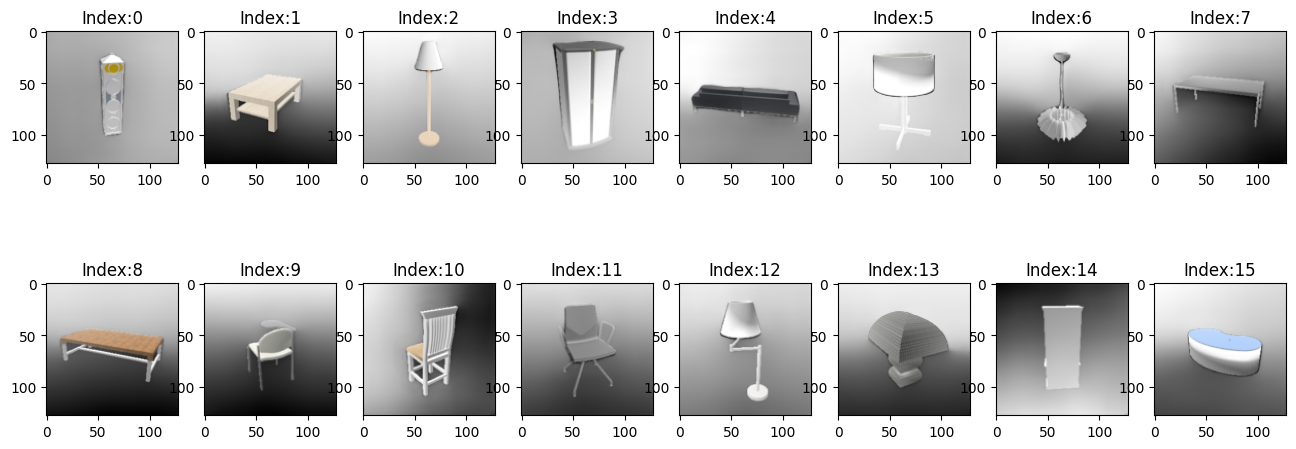

In [ ]:
category_losses = defaultdict(lambda: {'cd_sum': 0.0, 'emd_sum': 0.0, 'count': 0})
category_vis_counter = defaultdict(int)

with torch.no_grad():
    test_bar = tqdm(test_loader, unit='batch', leave=True, colour='#9E7EDA')

    for i_batch, (pred, gt, indices, categories) in enumerate(test_bar):
        pred = pred.to(DEVICE)                          # B x 4 x H x W
        gt = gt.to(DEVICE)                              # B x N x 3
        output = model(pred)
        output = output.view(gt.shape[0], -1, 3).type_as(gt)

        # compute loss
        cd_loss, _ = cd_loss_fn.forward(output, gt)
        emd_loss, _ = emd_loss_fn(output, gt)

        # group by category
        for i, cat in enumerate(categories):
            category_losses[cat]['cd_sum'] += cd_loss.item()
            category_losses[cat]['emd_sum'] += emd_loss.item()
            category_losses[cat]['count'] += 1

            # Update counter for that category
            category_vis_counter[cat] += 1

        test_bar.set_description(f"Testing")
        test_bar.set_postfix(cd=cd_loss.item(), emd=emd_loss.item())

        if i_batch == 5:
                save_multiple_images(pred[:None].permute(0, 2, 3, 1).detach().cpu(), plotly_path.joinpath('imgs.png'))
                watch_index = 5
                show_result(pred[watch_index], output[watch_index], gt[watch_index], plotly_path, watch_index)

# Final output
print("\n=== Evaluation Results by Category ===")
for category, stats in category_losses.items():
    avg_cd = stats['cd_sum'] / stats['count']
    avg_emd = stats['emd_sum'] / stats['count']
    print(f"Category: {category:10} | Chamfer Loss: {avg_cd:.6f} | EMD Loss: {avg_emd:.6f}")

In [ ]:
category_losses

defaultdict(<function __main__.<lambda>()>,
            {'chair': {'cd_sum': 18.168566115571593,
              'emd_sum': 733.7018171777017,
              'count': 11520},
             'sofa': {'cd_sum': 17.96408254162816,
              'emd_sum': 717.1538871121593,
              'count': 11520},
             'bench': {'cd_sum': 13.22019125353836,
              'emd_sum': 532.4013758040965,
              'count': 8688},
             'cabinet': {'cd_sum': 11.591548881791823,
              'emd_sum': 475.0719969891943,
              'count': 7392},
             'lamp': {'cd_sum': 18.4689905175037,
              'emd_sum': 709.1116228685714,
              'count': 11136},
             'table': {'cd_sum': 18.07175002178701,
              'emd_sum': 715.2605791743845,
              'count': 11520}})

### Inference

In [ ]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ["MiDaS_small", "DPT_Hybrid", "DPT_Large"]
midas = torch.hub.load("intel-isl/MiDaS", model_type[1])
midas.to(device)
midas.eval()

def transform_config(preprocess_list, resize):
    preprocess = []
    if 'grayscale' in preprocess_list:
        preprocess += [transforms.Grayscale(1)]
    if 'resize' in preprocess_list:
        preprocess += [transforms.Resize(resize)]
    if 'totensor' in preprocess_list:
        preprocess += [transforms.ToTensor()]
    return transforms.Compose(preprocess)

preprocess = ['resize', 'totensor']
transform = transform_config(preprocess, [128,128])

def open_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image)
    transformed_image_np =  transformed_image.numpy()
    transformed_image = transformed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        depth_prediction = midas(transformed_image)
    depth_prediction = depth_prediction.squeeze().cpu().numpy()
    depth_prediction = (depth_prediction - depth_prediction.min()) / (depth_prediction.max() - depth_prediction.min())
    depth_pil = Image.fromarray((depth_prediction * 255).astype(np.uint8))
    depth_map = transform(depth_pil).numpy()

    depth_map_np = depth_map.squeeze()
    image = np.concatenate((transformed_image_np, depth_map_np[None, :, :]), axis=0)

    return image


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


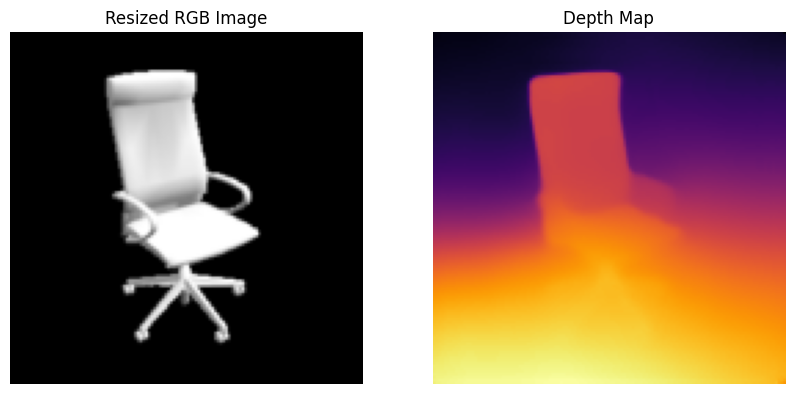

In [ ]:
import matplotlib.pyplot as plt

image_path = '03.png'
test_image = open_image(image_path)

plt.figure(figsize=(10,5))

# Plot RGB ảnh gốc
plt.subplot(1, 2, 1)
rgb_image = test_image[:3].transpose(1,2,0)  # từ (3,128,128) thành (128,128,3)
plt.imshow(rgb_image)
plt.title('Resized RGB Image')
plt.axis('off')

# Plot Depth map
plt.subplot(1, 2, 2)
depth_map = test_image[3]  # lấy kênh depth (shape 128x128)
plt.imshow(depth_map, cmap='inferno')
plt.title('Depth Map')
plt.axis('off')

plt.show()

In [ ]:
import torch
from torch import nn

class Depth2Point(nn.Module):
    def __init__(self, initial_point=0):
        super(Depth2Point, self).__init__()
        self.layer1 = self.conv_module(4, 32) # input: rgbd image
        self.layer2 = self.conv_module(32, 64)
        self.layer3 = self.conv_module(64, 128)
        self.layer4 = self.conv_module(128, 256)
        self.layer5 = self.conv_module(256, 256)
        self.layer6 = self.conv_module(256, 256)
        self.layer7 = self.conv_module(256, 256)
        self.fc1 = self.fc_module(256 * (3 + 256), 2048 * 5)
        self.fc2 = self.fc_module(2048 * 5, 2048 * 5)
        self.fc3 = self.fc_module(2048 * 5, 2048 * 4)
        self.fc4 = nn.Linear(2048 * 4, 2048 * 3)
        if initial_point == 2:
            self.initial_point = self.multiple_sphere()
        elif initial_point == 1:
            self.initial_point = self.fibonacci_sphere()
        else:
            self.initial_point = self.fibonacci_sphere()
    def forward(self, x):
        encoder_out = self.layer1(x)
        encoder_out = self.layer2(encoder_out)
        encoder_out = self.layer3(encoder_out)
        encoder_out = self.layer4(encoder_out)
        encoder_out = self.layer5(encoder_out)
        encoder_out = self.layer6(encoder_out)
        fv = self.layer7(encoder_out)
        batch_size = fv.shape[0]

        initial_pc_fv = torch.cat((
            self.initial_point.to(fv.device).view(1, 256, 3).repeat(batch_size, 1, 1),  # torch.Size([batch, 256, 3])
            fv.view(batch_size, 1, 256).repeat(1, 256, 1)  # torch.Size([batch, 256, 256])
        ), dim=2, )  # [batch_size, 256, 259]

        generator_out = self.fc1(initial_pc_fv.view(batch_size, -1))
        generator_out = self.fc2(generator_out)
        generator_out = self.fc3(generator_out)
        generator_out = self.fc4(generator_out)

        return generator_out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def fc_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Linear(in_num, out_num),
            nn.ReLU(),
        )

    def sphere(self, offset=(0, 0, 0)):
        u = torch.linspace(0, 2 * torch.pi, 16)
        v = torch.linspace(0, torch.pi, 16)
        x = torch.flatten(1 * torch.outer(torch.cos(u), torch.sin(v)))
        y = torch.flatten(1 * torch.outer(torch.sin(u), torch.sin(v)))
        z = torch.flatten(1 * torch.outer(torch.ones(torch.Tensor.size(u)), torch.cos(v)))
        return torch.stack((x + offset[0], y + offset[1], z + offset[2]), 1)

    def fibonacci_sphere(self, num_pts=256, offset=(0, 0, 0), radius=1):
        # https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
        indices = torch.arange(0, num_pts, dtype=torch.float32) + 0.5
        phi = torch.arccos(1 - 2*indices/num_pts)
        theta = torch.pi * (1 + 5**0.5) * indices
        x, y, z = torch.cos(theta) * torch.sin(phi), torch.sin(theta) * torch.sin(phi), torch.cos(phi)
        return torch.stack((x * radius + offset[0], y * radius + offset[1], z * radius + offset[2]), 1)

    def multiple_sphere(self):
        sphere_1 = self.fibonacci_sphere(128, (0, -0.8, 0.3), 0.3)
        sphere_2 = self.fibonacci_sphere(128, (0, 0.4, -0.2), 0.3)
        return torch.cat((sphere_1, sphere_2), 0)

In [ ]:
!pip install emd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 9.9 MB/s eta 0:00:00


In [ ]:
import torch
# from pytorch3d.loss import chamfer_distance as pt3d_cd
from torch import nn
from torch.autograd import Function

###  CD loss
class ChamferDistance():
    def __init__(self) -> None:
        # if not torch.are_deterministic_algorithms_enabled():
        #     self.loss_function = self.non_deterministic
        # else:
        #     self.loss_function = self.deterministic
        self.loss_function = self.deterministic

    def forward(self, p1, p2):
        return self.loss_function(p1, p2)

    def deterministic(self, p1, p2):
        s1 = torch.sum(torch.min(torch.cdist(p1, p2, p=2)**2, 2).values, 1)
        s2 = torch.sum(torch.min(torch.cdist(p2, p1, p=2)**2, 2).values, 1)
        return (torch.sum(s1) + torch.sum(s2)) / (p1.shape[-2] * s1.shape[0]), None

    # def non_deterministic(self, p1, p2):
    #     return pt3d_cd(p1, p2)

    def train_param(self, mode: bool = True):
        pass

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from math import ceil

def show_3d(data, mode='file', path=f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.html"):
    if torch.is_tensor(data):
        if data.requires_grad:
            data = data.detach()
        if not data.device == 'cpu':
            data = data.to('cpu')
        data = data.numpy()
    marker = {'size': 2, 'opacity': 0.8, }
    if data.shape[1] == 4:
        marker['color'] = data[:, 3]
    fig = go.Figure(
        data=[go.Scatter3d(
            x=data[:, 0],
            y=data[:, 1],
            z=data[:, 2],
            mode='markers',
            marker=marker
        )],
        layout=go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0}, scene=dict(aspectmode='data'))
    )
    if mode == 'browser':
        fig.show(renderer='browser')
    elif mode == 'file':
        fig.write_html(path)

def show_img(data, mode='browser', path='file.html'):
    if torch.is_tensor(data):
        if not data.device == 'cpu':
            data = data.to('cpu')
        data = data.numpy()

    if data.shape[0] == 4:
        data = data[:3]
    # convert to (H, W, C)
    data = data.transpose(1, 2, 0)
    img = px.imshow(data)
    if mode == 'browser':
        img.show(renderer='browser')
    elif mode == 'file':
        img.write_html(path)

def show_result(pred, output, gt, save_path, index):
    show_img(pred, mode='file', path=save_path.joinpath(f'pred_{index}.html'))
    show_3d(output, mode='file', path=save_path.joinpath(f'outputs_{index}.html'))
    show_3d(gt, mode='file', path=save_path.joinpath(f'gt_{index}.html'))

def save_multiple_images(images, path, columns=8):
    rows = ceil(len(images) / columns)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(2*columns, 3*rows))
    for i, axi in enumerate(ax.flat):
        try:
            target = images[i]
        except:
            break
        axi.imshow(target)
        axi.set_title(f'Index:{i}')
    plt.savefig(path)

In [ ]:
from pathlib import Path
import torch

model_path = Path("/content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-03-31_13-58-03/model/model_param.pt")
model = Depth2Point(initial_point=0).to(device)

checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

del checkpoint
torch.cuda.empty_cache()

input_tensor = torch.tensor(test_image).unsqueeze(0).to(device).float()

with torch.no_grad():
    predicted_point_cloud = model(input_tensor)
    predicted_point_cloud = predicted_point_cloud.float().view(-1, 3)

print("Predicted point cloud shape:", predicted_point_cloud.shape)

show_3d(predicted_point_cloud.squeeze(0).cpu(), path="test_output.html")

Predicted point cloud shape: torch.Size([2048, 3])


In [ ]:
def save_point_cloud_xyz(point_cloud, filename):
    if torch.is_tensor(point_cloud):
        point_cloud = point_cloud.detach().cpu().numpy()

    with open(filename, 'w') as f:
        for point in point_cloud:
            f.write(f"{point[0]} {point[1]} {point[2]}\n")

save_point_cloud_xyz(predicted_point_cloud, "predicted_cloud.xyz")


In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
 

In [ ]:
import open3d as o3d
import numpy as np

def save_point_cloud_ply(point_cloud, filename):
    if torch.is_tensor(point_cloud):
        point_cloud = point_cloud.detach().cpu().numpy()

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    o3d.io.write_point_cloud(filename, pcd)

# Gọi hàm này:
save_point_cloud_ply(predicted_point_cloud, "predicted_cloud.ply")

In [ ]:
import open3d as o3d

# Đọc file ply
pcd = o3d.io.read_point_cloud("your_cloud.ply")

# Hiển thị point cloud
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] Read PLY failed: unable to open file: your_cloud.ply
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


## Inference using model handler

In [ ]:
!pip install torchserve torch-model-archiver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 28.6 MB/s eta 0:00:00


In [ ]:
# prompt: copy /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-03-31_13-58-03/model/model_param.pt to /content/model_param.pt

# !cp /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-03-31_13-58-03/model/model_param.pt /content/model_param.pt

# !cp /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/checkpoint/checkpoint_13.pt /content/model_param.pt

!cp /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/model/model.pt /content/model.pt


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_file = 'model_param.pt'

checkpoint = torch.load(model_file, map_location=device, weights_only=False)

state_dict = checkpoint['model_state_dict']

torch.save(state_dict, 'model.pt')

In [ ]:
!cp /content/model.pt /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/model

In [ ]:
import torch
from handler import ModelHandler

class DummyContext:
    def __init__(self):
        self.system_properties = {"model_dir": "/content"}

# Tạo context giả
ctx = DummyContext()

# Khởi tạo ModelHandler
handler = ModelHandler()
handler.initialize(ctx)

# Đọc file ảnh test (giả định ảnh đã upload vào /content/test_image.jpg)
with open("/content/07.png", "rb") as f:
    image_bytes = f.read()

# Chuẩn bị input giả (giống TorchServe truyền)
data = [{"body": image_bytes}]

# Test từng bước:
input_tensor = handler.preprocess(data)
print("Preprocess output shape:", input_tensor.shape)

inference_result = handler.inference(input_tensor)
print("Inference output (3 điểm đầu):", inference_result[:3])

postprocess_result = handler.postprocess(inference_result)
print("Final output JSON:", postprocess_result)


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Preprocess output shape: torch.Size([1, 4, 128, 128])
Inference output (3 điểm đầu): [[0.3792867362499237, 0.8492248058319092, 0.6093236207962036], [0.43556880950927734, 0.8450354933738708, 0.3561258316040039], [0.3611707091331482, 0.8291914463043213, 0.6201860904693604]]
Final output JSON: [{'point_cloud': [[0.3792867362499237, 0.8492248058319092, 0.6093236207962036], [0.43556880950927734, 0.8450354933738708, 0.3561258316040039], [0.3611707091331482, 0.8291914463043213, 0.6201860904693604], [0.37584421038627625, 0.8356837034225464, 0.6246378421783447], [0.3719522953033447, 0.8238487243652344, 0.6231456995010376], [0.7191296815872192, 0.731732964515686, 0.4121039807796478], [0.5204369425773621, 0.654617965221405, 0.7277102470397949], [0.3620275557041168, 0.8187342286109924, 0.6190205812454224], [0.38240984082221985, 0.839564859867096, 0.6237510442733765], [0.5110331773757935, 0.8176566362380981, 0.46300315856933594], [0.3649100661277771, 0.8308238983154297, 0.6156932711601257], [0.6565

In [ ]:
!torch-model-archiver \
--model-name model \
--version 2.0 \
--serialized-file model.pt \
--handler handler.py \
--extra-files "model.py" \
--export-path model_artifacts \
--force

In [ ]:
!unzip -l model_artifacts/model.mar

Archive:  model_artifacts/model.mar
  Length      Date    Time    Name
---------  ---------- -----   ----
3680894560  2025-05-13 04:09   model.pt
     3488  2025-05-13 04:08   model.py
     1708  2025-05-13 04:09   handler.py
      227  2025-05-13 04:13   MAR-INF/MANIFEST.json
---------                     -------
3680899983                     4 files


In [ ]:
!cp /content/model_artifacts/model.mar /content/drive/MyDrive/data/Capstone/runs/Depth2Point/2025-04-13_20-36-37/model/model.mar

In [ ]:
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=R9JQ1ZNuZLDMaHpqnTFUI6s1m6IAS1&prompt=consent&token_usage=remote&access_type=offline&code_challenge=PXXc9Q3xyRHWa6KLrbiPOG7vuujCmlHb-XsWtXlWV2Q&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 

Command killed by keyboard interrupt

^C


In [ ]:
BUCKET_NAME = "3d-reconstruction-bucket"
BUCKET_URI = f"gs://{BUCKET_NAME}/"
FULL_GCS_PATH = f"{BUCKET_URI}model_artifacts"

!gsutil cp -r model_artifacts $BUCKET_URI

Copying file://model_artifacts/model.mar [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/3.2 GiB.                                      
